In [13]:
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.he as he
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/examples/full_workflow'
mushroom_dir = os.path.join(run_dir, f'mushroom') # where mushroom results will be saved
Path(mushroom_dir).mkdir(parents=True, exist_ok=True)

## specify inputs

In [6]:
metadata = yaml.safe_load(open(os.path.join(run_dir, 'registered', 'metadata.yaml')))
yaml.safe_dump(metadata, sys.stdout)

resolution: 1.0
sections:
- data:
  - dtype: visium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad
  - dtype: he
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif
  position: 0
  sid: S18-9906-U1
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad
  position: 5
  sid: S18-9906-U2
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff
  position: 10
  sid: S18-9906-U3
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad
  position: 40
  sid: S18-9906-U9
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s4_S18-9906-U10_multiplex.ome.tiff
  positi

In [7]:
geo = json.load(open('/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.geojson'))
geo

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '43fe8244-ecb7-4cd4-9cbc-0d6200f56ecd',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[7097, 2269],
      [1383, 2320],
      [1525, 8023],
      [5765, 8044],
      [7400, 6943],
      [7097, 2269]]]},
   'properties': {'objectType': 'annotation'}}]}

In [8]:
polygons = []
for feat in geo['features']:
    pts = feat['geometry']['coordinates'][0]
    polygons.append(np.asarray(pts))
polygons

[array([[7097, 2269],
        [1383, 2320],
        [1525, 8023],
        [5765, 8044],
        [7400, 6943],
        [7097, 2269]])]

In [9]:
size = he.get_size('/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif')
img = he.read_he('/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif')
size = img.shape[:2]
size

(8695, 8460)

In [10]:
mask = np.zeros(size, dtype=bool)
for pts in polygons:
    mask |= skimage.draw.polygon2mask(size, pts[:, [1, 0]])
mask.shape

(8695, 8460)

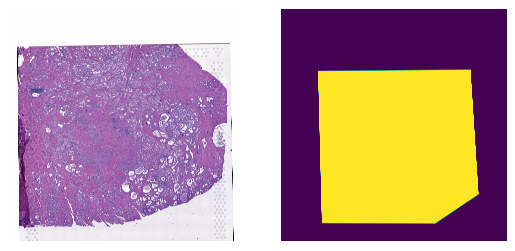

In [11]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(img)
axs[1].imshow(mask)
for ax in axs:
    ax.axis('off')

In [14]:
mask_fp = '/data/estorrs/sandbox/mask.tif'
tifffile.imwrite(mask_fp, mask)

In [15]:
DEFAULT_CONFIG

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': None,
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data_mask': None}}

In [16]:
config = deepcopy(DEFAULT_CONFIG)
config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': metadata['resolution'] / 50.,
        'out_dir': os.path.join(mushroom_dir, 'outputs'),
        'accelerator': 'gpu',
        'data_mask': mask_fp,
        'steps_per_epoch': 200,
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff'}],
   'position': 10,
   'sid': 'S18-9906-U3'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad'}],
   'position': 40,
   'sid': 'S18-9906-U9'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data

In [17]:
# fps = [mapping['filepath'] 
#        for item in config['sections']
#        for mapping in item['data']
#        if 'multiplex' == mapping['dtype']]
# multiplex.get_channel_counts(fps)

In [18]:
config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': .01 # lower resolution for visium
        }
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff'}],
   'position': 10,
   'sid': 'S18-9906-U3'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad'}],
   'position': 40,
   'sid': 'S18-9906-U9'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data

## train mushroom

In [25]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['S18-9906-U1', 'S18-9906-U16']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U1
INFO:root:generating image data for section S18-9906-U16
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-9906-U1', 'he'), ('S18-9906-U16', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['S18-9906-U3', 'S18-9906-U10', 'S18-9906-U18', 'S18-9906-U25']
INFO:root:processing sections
INFO:root:generating image data for secti

In [26]:
mushroom.section_ids

[('S18-9906-U1', 'visium'),
 ('S18-9906-U1', 'he'),
 ('S18-9906-U2', 'xenium'),
 ('S18-9906-U3', 'multiplex'),
 ('S18-9906-U9', 'xenium'),
 ('S18-9906-U10', 'multiplex'),
 ('S18-9906-U16', 'visium'),
 ('S18-9906-U16', 'he'),
 ('S18-9906-U17', 'xenium'),
 ('S18-9906-U18', 'multiplex'),
 ('S18-9906-U24', 'xenium'),
 ('S18-9906-U25', 'multiplex')]

In [27]:
mushroom.train()

INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/he_chkpts/last-v3.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.914    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/multiplex_chkpts/last-v3.ckpt
INFO:root:starting training for visium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/visium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 24.8 M
------------------------------
24.8 M    Trainable params
0         Non-trainable params
24.8 M    Total params
99.234    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/visium_chkpts/last-v3.ckpt
INFO:root:starting training for xenium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/xenium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.838    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs/xenium_chkpts/last-v3.ckpt


In [28]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

he


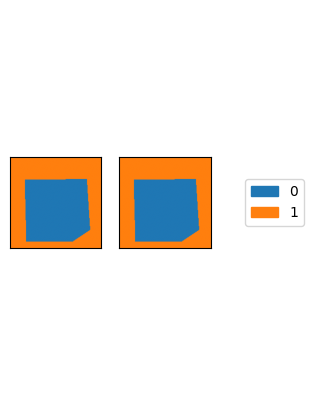

multiplex


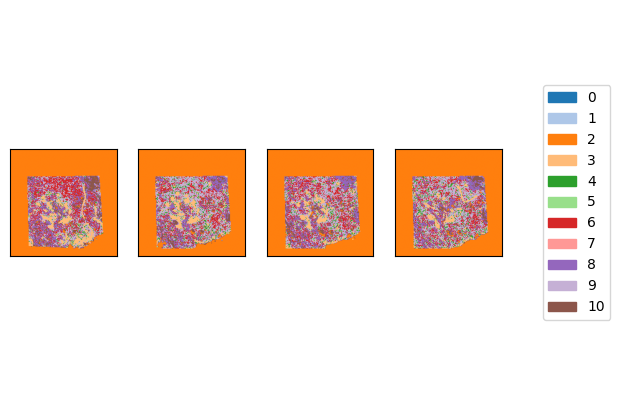

visium


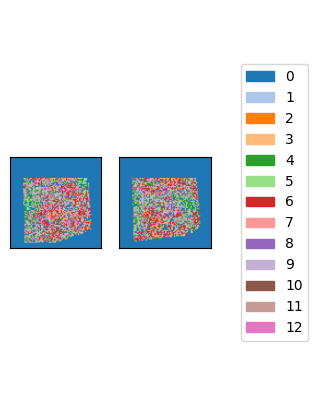

xenium


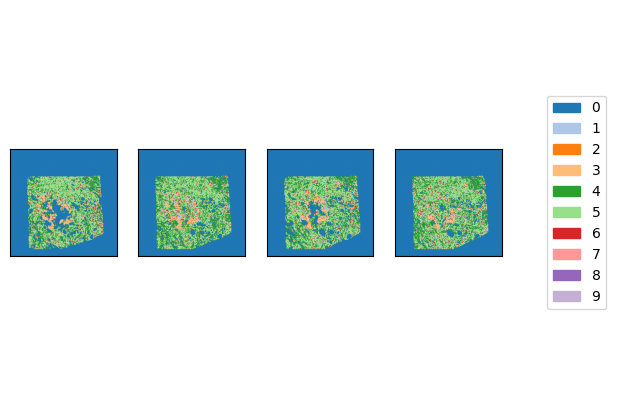

In [29]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_clusters(dtype)
    plt.show()

he


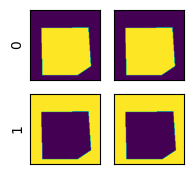

multiplex


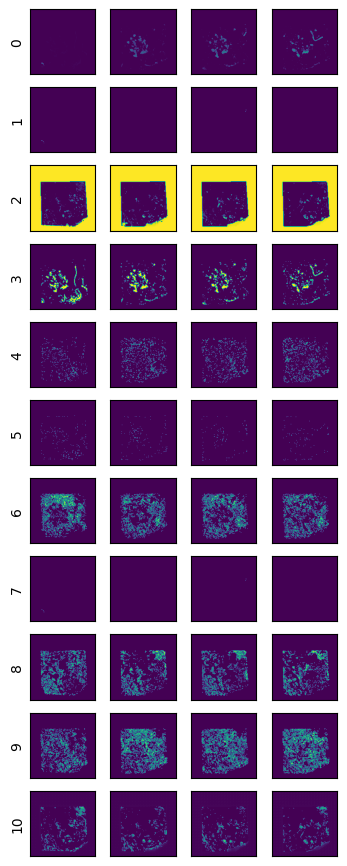

visium


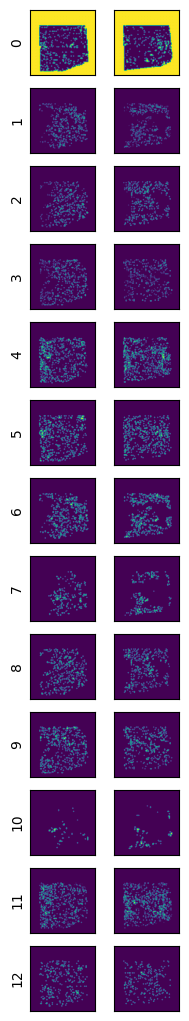

xenium


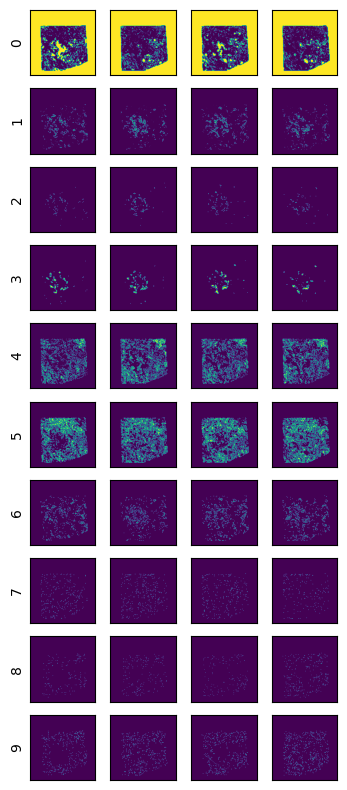

In [30]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_cluster_probs(dtype)
    plt.show()

In [31]:
%%time
z_scaler = .1
cluster_res = 1.5
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=0, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 24649 edges
INFO:root:2375 edges remaining after filtering
INFO:root:157 of 157 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 8 clusters


CPU times: user 34.3 s, sys: 3.12 s, total: 37.4 s
Wall time: 6.88 s


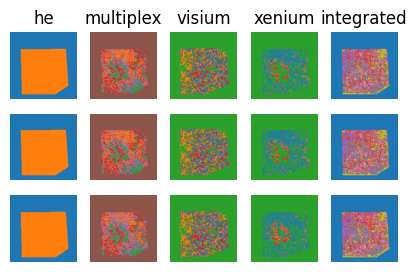

In [32]:
mushroom.display_volumes(positions=[1,2,3])

In [33]:
%%time
z_scaler = .1
cluster_res = 1.2
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=1, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 254016 edges
INFO:root:30688 edges remaining after filtering
INFO:root:504 of 504 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 6 clusters


CPU times: user 42.3 s, sys: 3.7 s, total: 46 s
Wall time: 7.54 s


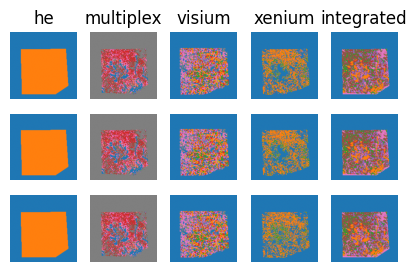

In [34]:
mushroom.display_volumes(positions=[1,2,3])

In [35]:
%%time
z_scaler = .1
cluster_res = 1.
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=2, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 741321 edges
INFO:root:89925 edges remaining after filtering
INFO:root:861 of 861 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 8 clusters


CPU times: user 1min 43s, sys: 30.5 s, total: 2min 14s
Wall time: 10.7 s


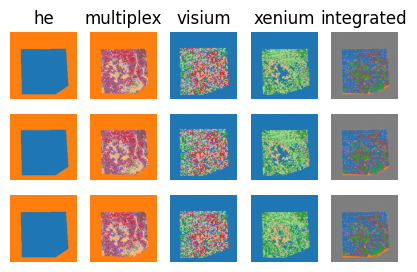

In [36]:
mushroom.display_volumes(positions=[1,2,3])

In [37]:
dtype_to_df = mushroom.calculate_cluster_intensities()
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'visium', 'xenium'])

In [38]:
dtype_to_df['multiplex']

,AMACR,AR,CD20 (D),CD31 (D),CD3e,CD4,CD45(D),CD68,CD8,CK14,...,Foxp3,HLA-DR,Ki67,LYVE1,Pan-Cytokeratin,Podoplanin,SMA (D),STEAP4,Vimentin,p63
0,0.502902,1.692207,1.844912,3.640447,3.398131,3.144727,2.866821,4.115587,1.526728,0.946659,...,0.176937,2.955137,1.261355,2.713194,2.347581,1.583829,2.658914,0.290853,3.600099,0.997853
1,0.334076,1.115786,1.066901,2.099624,2.074169,1.938257,2.040857,2.756093,0.878472,0.568484,...,-0.048826,1.774105,0.675224,1.747926,1.570672,0.996625,1.948060,0.278580,2.159836,0.521398
2,-0.225769,-0.800205,-0.773608,-1.555049,-1.261672,-1.372190,-1.597379,-1.317807,-0.359784,-0.212429,...,-0.135182,-1.100577,-0.351903,-1.261254,-1.261853,-0.404385,-1.564119,-0.204368,-1.771929,-0.244391
3,0.534868,3.227273,3.476657,6.521817,5.768512,5.987908,4.799478,7.608765,1.961022,1.499310,...,0.457028,5.999909,2.169313,4.891555,4.548890,2.515044,4.313842,0.730812,7.449856,1.140319
4,0.307039,1.985167,1.821663,3.560942,3.205858,3.477317,3.083555,4.843197,0.902070,0.772791,...,0.203152,3.209753,0.942223,2.916300,2.861094,1.028051,2.918798,0.343046,4.451037,0.590079
5,0.239101,1.131256,1.075784,2.100146,1.919351,2.087771,2.156241,3.110246,0.586527,0.505054,...,0.066676,1.755989,0.472008,1.848787,1.831657,0.495371,1.950109,0.201258,2.639377,0.396420
6,0.222429,1.135335,1.038622,2.034970,1.869001,2.071265,2.133227,3.081390,0.524965,0.475861,...,0.075065,1.733542,0.413734,1.821077,1.822505,0.421450,1.964111,0.175959,2.642116,0.365012
7,0.406638,2.386025,2.540359,4.615134,4.184361,4.271833,3.663350,5.518407,1.581871,1.133423,...,0.256130,4.163321,1.507992,3.620490,3.314905,1.896592,3.386272,0.520113,5.215087,0.894583
8,0.216937,0.978041,0.866699,1.781347,1.618308,1.783014,1.900955,2.770411,0.449634,0.402933,...,0.063168,1.496123,0.334119,1.602687,1.596820,0.312568,1.754698,0.153681,2.297398,0.313318
9,0.218536,1.374144,1.233886,2.403982,2.192371,2.444145,2.402836,3.586004,0.567647,0.541839,...,0.096154,2.082199,0.498690,2.114565,2.116199,0.516091,2.248015,0.219504,3.142688,0.401931


In [45]:
mushroom.section_ids

[('S18-9906-U1', 'visium'),
 ('S18-9906-U1', 'he'),
 ('S18-9906-U2', 'xenium'),
 ('S18-9906-U3', 'multiplex'),
 ('S18-9906-U9', 'xenium'),
 ('S18-9906-U10', 'multiplex'),
 ('S18-9906-U16', 'visium'),
 ('S18-9906-U16', 'he'),
 ('S18-9906-U17', 'xenium'),
 ('S18-9906-U18', 'multiplex'),
 ('S18-9906-U24', 'xenium'),
 ('S18-9906-U25', 'multiplex')]

In [51]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='xenium')
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'visium', 'xenium'])

In [52]:
dtype_to_df['multiplex']

,AMACR,AR,CD20 (D),CD31 (D),CD3e,CD4,CD45(D),CD68,CD8,CK14,...,Foxp3,HLA-DR,Ki67,LYVE1,Pan-Cytokeratin,Podoplanin,SMA (D),STEAP4,Vimentin,p63
0,-0.182825,-0.622841,-0.602954,-1.216861,-0.967500,-1.057598,-1.261395,-0.916663,-0.270098,-0.146049,...,-0.115521,-0.832140,-0.272274,-0.978201,-0.984222,-0.315730,-1.245812,-0.165846,-1.370356,-0.185833
1,0.388101,2.418247,2.462572,4.666667,4.148459,4.406387,3.704409,5.819915,1.315148,1.058492,...,0.305570,4.259367,1.412984,3.636735,3.464669,1.607035,3.371733,0.504485,5.539462,0.792349
2,0.465314,2.933996,3.068098,5.791008,5.097165,5.396068,4.383739,6.971265,1.639285,1.299342,...,0.405656,5.330420,1.836932,4.402474,4.158622,2.091994,3.936577,0.647817,6.758322,0.969137
3,0.516773,3.197388,3.414618,6.411069,5.653892,5.916687,4.745828,7.524284,1.896134,1.465118,...,0.460371,5.917605,2.101149,4.825170,4.508477,2.433470,4.258312,0.725991,7.372933,1.102825
4,0.206272,1.095731,0.976681,1.980814,1.791938,1.989869,2.003908,3.032542,0.467078,0.438567,...,0.076207,1.712716,0.395929,1.746552,1.737422,0.378431,1.854606,0.170726,2.562780,0.330330
5,0.242534,1.387479,1.293053,2.514423,2.289355,2.498880,2.403205,3.608764,0.655676,0.578003,...,0.112128,2.197212,0.589864,2.152456,2.122575,0.632401,2.229706,0.236596,3.186547,0.437004
6,0.292178,1.767867,1.721131,3.280067,2.974883,3.180501,2.857730,4.380507,0.919307,0.763627,...,0.180006,2.938278,0.898642,2.682018,2.596454,1.013147,2.646337,0.330897,4.026720,0.575259
7,0.199332,1.153002,1.021298,2.079406,1.854502,2.094971,2.064895,3.201757,0.442955,0.446916,...,0.076994,1.800588,0.420773,1.822271,1.823464,0.381760,1.892410,0.182532,2.692361,0.336920
8,0.223537,1.230485,1.111145,2.242565,2.048125,2.255232,2.238233,3.335155,0.561415,0.497609,...,0.092405,1.938208,0.458973,1.957019,1.951676,0.458360,2.098651,0.179013,2.912552,0.379111
9,0.214925,1.200818,1.062411,2.161827,1.961372,2.187261,2.190875,3.284504,0.498697,0.468395,...,0.087381,1.863971,0.422031,1.903473,1.908854,0.395970,2.046401,0.170987,2.835703,0.353098


In [41]:
out_dir = os.path.join(mushroom_dir, 'outputs')
prefix = os.path.join(out_dir, f'clusters')
for dtype in mushroom.dtype_to_volume.keys():
    for i in range(3):
        root = prefix + f'_{dtype}_axis{i}'
        is_probs = False
        volume = mushroom.dtype_to_volume[dtype]
        vis_utils.volume_to_gif(volume, is_probs, root + '_section.gif', axis=i)
        
        if i in [1, 2]:
            rgb = vis_utils.display_labeled_as_rgb(volume[0], preserve_indices=True)
            vis_utils.save_reference_gif(rgb, root + '_ref.gif', axis=i-1)

In [42]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom/outputs
